# Scripting with GeoIPS

This tutorial is intended to teach users how GeoIPS plugins can be used in
custom scripts.

Most current documentation for GeoIPS describes how to use the system
in a manner intended for near real-time processing and does not focus on
algorithm development and scripted use. However, it is possible, and sometimes
simpler, to use GeoIPS plugins in your own custom scripts. GeoIPS plugin
`interfaces` can be directly imported and used to load individual plugins. Those
plugins can then be called to manipulate your data.

## Plugins introduced

In this tutorial, we will use the following plugin types:
- reader
- sector
- interpolator
- output_formatter
- filename_formatter

## System requirements

- **CPU:** 1 CPU
- **RAM:** 40GB as the notebook is written, but could use more if modified.
  Reading the entire full-disk ABI image can take up to 100GB.
- **Disk Space:** 3GB storage space.

## Important notes
This notebook downloads approximately 2GB of data and produces another 1GB. It
is stored in the location reported by running the next cell.

This notebook makes an attempt at cleaning up after itself, but it is
recommended that, when done using this notebook, you check to be sure that the
directory reported by the next cell has been deleted.

## Setup
Run the cell below to set up your environment. This will initialize a 
session-specific storage 
directory, add it to the global notebook environment, and add a hook that 
attempts to clean up the temporary storage when the notebook is closed.

❗
***Important:*** While this notebook makes an effort to clean up after itself,
if you are running this notebook on your own system, ***it is advisable to
manually delete the temporary directory reported above when you are done using 
the notebook.***

# Install ABI test data
Running the command below will use the GeoIPS CLI to download and install test data for ABI. The
download will consume about 2GB of disk space and will contain one complete
full-disk level 1-B dataset for both GOES-16 and GOES 18.

The data are installed by calling `geoips config install test_data_abi`. Other test datasets are
available. A list of available test datasets can be obtained by calling `geoips list test-datasets`.

📝 Note: If this command is run multiple times, it will not re-download the same dataset. If you need to update
a dataset, you will need to delete it, then re-download it.

In [ ]:
%%bash
echo "Installing ABI test data to ${GEOIPS_TESTDATA_DIR}"

# This command downloads the test_data_abi dataset
# This will be installed into $GEOIPS_TESTDATA_DIR
geoips config install test_data_abi

Installing ABI test data to /tmp/geoips_tutorial_tempdirs/geoips_tutorial_tmp_e8daa153e4b445d5993c33cc87ba9d80/test_data
Test dataset 'test_data_abi' already exists under '/tmp/geoips_tutorial_tempdirs/geoips_tutorial_tmp_e8daa153e4b445d5993c33cc87ba9d80/test_data/test_data_abi*/'. See that location for the contents of the test dataset.

Until this warning is removed, do not rely on the CLI to be static.
Please feel free to test the CLI and report any bugs or comments as an issue here:
https://github.com/NRLMMD-GEOIPS/geoips/issues/new/choose



# Plugin Interfaces

GeoIPS provides programmatic access to its plugins through plugin `interfaces`.
Each plugin type (e.g. readers, algorithms, etc.) belongs to an interface.
Interfaces are used to load specific plugins and provide some limited ability to
discover plugins.

## List the available interfaces
While the CLI provides more useful interrogation functions, information about the GeoIPS artifacts can also be obtained programmatically. To retrieve a list of the available plugin interfaces (plugin types), call `geoips.interfaces.list_available_interfaces()`.

The cell below will print the available interfaces. There are several module-based and yaml-based interfaces in core GeoIPS, but no current text_based interfaces.

📝 Note: Additional details about each interface can be obtained via the CLI by calling `geoips describe interface <interface-name>`

In [5]:
from pprint import pprint

# Import the interfaces module
from geoips import interfaces

# List the available interface
print("Available interfaces:")
print("---------------------")
pprint(interfaces.list_available_interfaces())

Available interfaces:
---------------------
{'module_based': ['algorithms',
                  'colormappers',
                  'coverage_checkers',
                  'databases',
                  'filename_formatters',
                  'interpolators',
                  'output_checkers',
                  'output_formatters',
                  'procflows',
                  'readers',
                  'sector_adjusters',
                  'sector_metadata_generators',
                  'sector_spec_generators',
                  'title_formatters'],
 'text_based': [],
 'yaml_based': ['feature_annotators',
                'gridline_annotators',
                'product_defaults',
                'products',
                'sectors',
                'workflows']}


## Import the sectors interface and list the available sector plugins
Each interface has plugins registered to it. Those plugins are accessed via the interface object. To access sector plugins, use the `sectors` interface.

The cell below imports the sectors interface and prints a list of the available sector plugins.

In [6]:
# Import the sectors interface, specifically
from geoips.interfaces import sectors

# List the available sectors
print("Available sectors:")
print("------------------")
pprint(sorted([sect.name for sect in sectors.get_plugins()]))

Available sectors:
------------------
['Guam',
 'Hawaii',
 'abu_dhabi',
 'africa',
 'african_horn',
 'alaska',
 'asia',
 'australia',
 'beijing',
 'brazil',
 'cairo',
 'canada',
 'caribbean',
 'central_america',
 'conus',
 'delhi',
 'denver',
 'e_pacific',
 'europe',
 'ewsg',
 'france',
 'geokompsat',
 'geokompsat_subsector',
 'global',
 'global_20km_longlat',
 'global_cylindrical',
 'goes_east',
 'goes_east_subsector',
 'goes_west',
 'goes_west_20km_longlat',
 'himawari',
 'indian_basin',
 'japan',
 'korea',
 'mediterranean',
 'melbourne',
 'meteosat_africa',
 'meteosat_eu',
 'meteosat_europe',
 'meteosat_indian_ocean',
 'meteosat_iodc',
 'mexico_city',
 'middle_east',
 'ne_asia',
 'north_pole',
 'paris',
 'rio_de_janeiro',
 'russia',
 'saskatchewan',
 'se_asia',
 'south_america',
 'south_china_sea',
 'south_pole',
 'tc_0p1km_3200x3200',
 'tc_1km_1024x1024',
 'tc_1km_1400x1400',
 'tc_1km_2500x2500',
 'tc_1km_3200x3200',
 'tc_2km_1024x1024',
 'tc_2km_1400x1400',
 'tc_2km_1600x1600',
 '

## Import the readers interface and list the available readers plugins
All interfaces behave the same. The cell below imports the readers interface and lists the available readers. Unlike the CLI, it does not provide additional context for the plugins.

📝 Note: At the time of writing this notebook, plugins do not have useful string representations so their names must be accessed via their `name` attribute. There is a pending issue to fix this. Once fixed, there would be no need for the loop used here.

In [7]:
# Import the readers interface, specifically
from geoips.interfaces import readers

# List the available readers
print("Available readers:")
pprint(sorted([rdr.name for rdr in readers.get_plugins()]))

Available readers:
['abi_l2_netcdf',
 'abi_netcdf',
 'ahi_hsd',
 'ami_netcdf',
 'amsr2_netcdf',
 'amsr2_remss_winds_netcdf',
 'amsua_mhs_mirs',
 'amsub_hdf',
 'ascat_uhr_netcdf',
 'atms_hdf5',
 'aws_netcdf',
 'clavrx_hdf4',
 'clavrx_netcdf4',
 'cygnss_netcdf',
 'ewsg_netcdf',
 'fci_netcdf',
 'geoips_netcdf',
 'gfs_grib',
 'gmi_hdf5',
 'imerg_hdf5',
 'mimic_netcdf',
 'modis_hdf4',
 'saphir_hdf5',
 'sar_winds_netcdf',
 'scat_knmi_winds_netcdf',
 'scat_noaa_winds_netcdf',
 'seviri_hrit',
 'sfc_winds_text',
 'smap_remss_winds_netcdf',
 'smos_winds_netcdf',
 'ssmi_binary',
 'ssmis_binary',
 'viirs_l2_netcdf',
 'viirs_netcdf',
 'viirs_sdr_hdf5',
 'wfabba_ascii',
 'windsat_idr37_binary',
 'windsat_remss_winds_netcdf']


## Loading a Sector
Plugins can be loaded by calling the `get_plugin()` method of their interface. Below, we load the `conus` sector.

Each plugin can be inspected to better understand it. Yaml-based plugins like Sectors have a `yaml` attribute that prints the original yaml. `sector` plugins, additionally, have an `area_definition` attribute that contains the pyresample `AreaDefinition` for the sector

NOTE TO SELF! Consider running `geoips test sector` and `geoips test sector --overlay` here.

In [8]:
# Load the CONUS sector and inspect it
conus = sectors.get_plugin("conus")

# Print the sector's details
print("Sector YAML definition:")
print("-----------------------")
pprint(conus.yaml)
print("\nArea Definition:")
print("----------------")
pprint(conus.area_definition)


Sector YAML definition:
-----------------------
{'abspath': '/home/jsolbrig/anaconda3/envs/geoips-review/lib/python3.11/site-packages/geoips/plugins/yaml/sectors/static/conus.yaml',
 'docstring': 'Continental United States.',
 'family': 'area_definition_static',
 'interface': 'sectors',
 'metadata': {'region': {'area': 'Continental',
                         'city': 'x',
                         'continent': 'NorthAmerica',
                         'country': 'UnitedStates',
                         'state': 'x',
                         'subarea': 'x'}},
 'name': 'conus',
 'package': 'geoips',
 'relpath': 'plugins/yaml/sectors/static/conus.yaml',
 'spec': {'area_extent': {'lower_left_xy': [-3600000, -1800000],
                          'upper_right_xy': [3600000, 1800000]},
          'area_id': 'conus',
          'description': 'Continental United States',
          'projection': {'a': 6371228.0,
                         'lat_0': 39.5,
                         'lon_0': -98.35,
       

In [9]:
# Load the ABI L1B NetCDF reader
abi_reader = readers.get_plugin("abi_netcdf")

# Print the reader's details (only works in IPython/Jupyter)
abi_reader?

Signature:     
abi_reader(
    fnames,
    metadata_only=False,
    chans=None,
    area_def=None,
    self_register=False,
    geolocation_cache_backend='memmap',
    cache_chunk_size=None,
    cache_data=False,
    cache_solar_angles=False,
    resource_tracker=None,
    roi=None,
)
Type:           ReadersPlugin
String form:    <geoips.interfaces.base.ReadersPlugin object at 0x7fc4122cb7d0>
File:           ~/anaconda3/envs/geoips-review/lib/python3.11/site-packages/geoips/interfaces/base.py
Docstring:      Standard GeoIPS xarray dictionary based ABI NetCDF data reader.
Call docstring:
Read ABI NetCDF data from a list of filenames.

Parameters
----------
fnames : list
    * List of strings, full paths to files
metadata_only : bool, default=False
    * Return before actually reading data if True
chans : list of str, default=None
    * List of desired channels (skip unneeded variables as needed).
    * Include all channels if None.
area_def : pyresample.AreaDefinition, default=None
   

## Reading ABI Data
Using the various plugins is straightforward. Using their particular call signature, simply call the plugin. To read ABI data, we construct a list of input files, then pass them to the ABI reader. The reader will read the files and output the results as a dictionary of xarrays where each key represents a data resolution.

In this case, we also specify two optional arguments:
- `area_def` tells the reader to use nearest neighbor interpolation to return data for a particular sector.
- `chans` tells the reader which channels to read.

Providing both of these options helps us limit the memory footprint of the data. Reading the full dataset requires about 100GB of RAM (which is expensive when serving this notebook in the cloud).

In [10]:
from glob import glob
import xarray as xr

# Collect the file list
files = glob(f"{temp_dir}/test_data/test_data_abi/data/goes16_20200918_1950/*")

# Read in ABI test data
# - files must be a list, not a glob pattern
# - We pass the area sector's area definition here to only read the data that we need.
#   This is significantly faster and uses much less memory (and costs less in cloud costs!)
#   Note that this will read the portion of the data that covers the area definition
#   but will keep all pixels in that region.
print("Reading ABI data")
# Describe what is returned here.
xarray_dict = abi_reader(files, area_def=conus.area_definition, chans=["B01Ref", "B02Ref", "B03Ref"])
print(xarray_dict.keys())
pprint(xarray_dict)


Reading ABI data
dict_keys(['conus', 'METADATA'])
{'METADATA': <xarray.Dataset> Size: 0B
Dimensions:  ()
Data variables:
    *empty*
Attributes: (12/13)
    file_metadata:                      {'B01': {'file_info': {'id': 'c081667...
    start_datetime:                     2020-09-18 19:50:20.526449
    end_datetime:                       2020-09-18 19:59:51.324280
    source_name:                        abi
    data_provider:                      noaa
    source_file_names:                  ['OR_ABI-L1b-RadF-M6C01_G16_s20202621...
    ...                                 ...
    longitude_of_projection_origin:     -75.0
    perspective_point_height:           35786023.0
    platform_name:                      goes-16
    area_definition:                    Area ID: conus\nDescription: Continen...
    area_id:                            conus
    interpolation_radius_of_influence:  5000.0,
 'conus': <xarray.Dataset> Size: 207MB
Dimensions:                  (dim_0: 1200, dim_1: 2400)
Dim

# Interpolating Data
Data can be interpolated to a new domain using interpolator plugins. While our data is already interpolated (to save on RAM) we can still re-apply the interpolation as an example.

Below, we import the interpolators interface, load the `interp_nearest` plugin, then interpolate each data resolution separately.

Note: Currently, each resolution needs to be interpolated separately, requiring a loop. Additionally, the `METADATA` dataset needs to be skipped. We have issues to address both of these issues in a backwards compatible way.

In [45]:
from geoips.interfaces import interpolators

print("Loading interpolator plugin")
interpolator = interpolators.get_plugin("interp_nearest")

# Initialize an empty xarray instance into which the output will be placed
# This is a step that should disappear in the near future
interp_data = xr.Dataset()
for res in xarray_dict.keys():
    if res == "METADATA":
        continue
    print(f"Interpolating {res} resolution data")
    interp_data = interpolator(conus.area_definition, xarray_dict[res], interp_data, list(xarray_dict[res].data_vars))
pprint(interp_data)

Loading interpolator plugin
Interpolating conus resolution data
<xarray.Dataset> Size: 207MB
Dimensions:                  (dim_0: 1200, dim_1: 2400)
Dimensions without coordinates: dim_0, dim_1
Data variables:
    latitude                 (dim_0, dim_1) float64 23MB nan nan ... 23.33 23.33
    longitude                (dim_0, dim_1) float64 23MB nan nan ... -65.99
    B01Ref                   (dim_0, dim_1) float64 23MB nan nan ... 0.1009
    B02Ref                   (dim_0, dim_1) float64 23MB nan nan ... 0.03917
    B03Ref                   (dim_0, dim_1) float64 23MB nan nan ... 0.02505
    satellite_zenith_angle   (dim_0, dim_1) float64 23MB nan nan ... 29.25 29.26
    satellite_azimuth_angle  (dim_0, dim_1) float64 23MB nan nan ... 21.77 21.82
    solar_zenith_angle       (dim_0, dim_1) float64 23MB nan nan ... 54.18 54.2
    solar_azimuth_angle      (dim_0, dim_1) float64 23MB nan nan ... 4.439 4.439
Attributes:
    start_datetime:                     2020-09-18 19:50:20.526449
 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.004916947514189474..1.1609802384000314].


(1200, 2400, 3)
inline


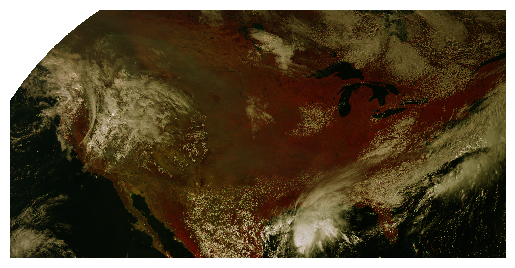

In [48]:
%matplotlib inline

import numpy as np
import matplotlib
from matplotlib import pyplot as plt

image = np.stack(
    [
        interp_data["B03Ref"].data,
        interp_data["B02Ref"].data,
        interp_data["B01Ref"].data ** 2,
    ],
    axis=-1,
)
print(image.shape)
print(matplotlib.get_backend())
plt.imshow(image)
plt.axis("off")
plt.show()

In [ ]:
from geoips.interfaces import algorithms

# Load the single-channel algorithm